# Tight-binding and scattering formalism

## Goal for today

**simulate a quantum point contact**
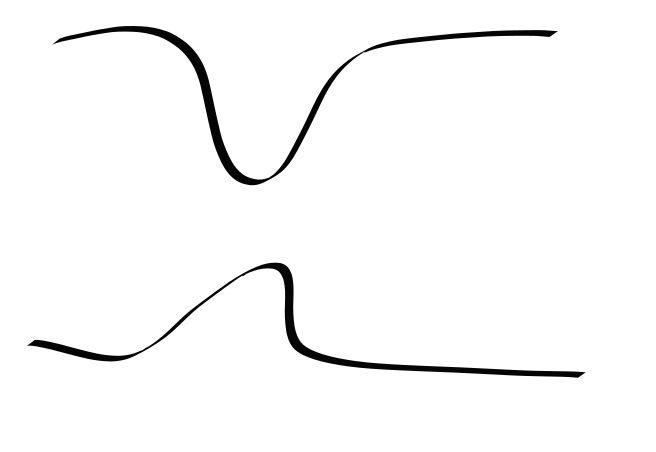

## Warm-up: discretization of a particle in a box

Schrödinger equation:

$$H = \frac{p^2}{2m},\quad \psi(0) = \psi(L) = 0 $$

Goal: find $\psi_n$, $E_n$.

### What we expect to find

$$ \psi_n(x) = sin(n \pi x/L), \quad E_n = \pi^2 n^2 / 2m L^2$$

In [ ]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np

pi = np.pi

x = np.linspace(0, 1, 100)

def psi(x, n, L=1):
    return np.sin(pi*n*x/L)

for n in (1, 2, 3):
    pyplot.plot(x, psi(x, n))

### Tight-binding approach

### Finite differences for continuum Hamiltonians

####  Discretizing a 1D Hamiltonian

The usual trick is to use the method of *finite differences*. We approximate:

$$ \frac{d \psi(x)}{d x} \approx \frac{\psi(x+a) - \psi(x-a)}{2a}$$

$$ \frac{d \psi(x)}{d x^2} \approx \frac{2 \psi(x) - \psi(x-a) - \psi(x+a)}{a^2}$$

We see that now only the wave function at points that are spaced by $a$ are entering here. Hence we can replace the continuous coordinate space by a discrete lattice with lattice spacing $a$:

<img src="images/discretization.svg" style="width: 70%"></img>

where $x_i = i a$

In the finite difference approximation, the Schrödinger equation then reads

$$ H \psi(x_i) = \frac{\hbar^2}{2 m^* a^2} \left[2 \psi(x_i) - \psi(x_i-a) - \psi(x_i+a) \right] = E \psi(x_i) $$

It is useful to define the quantity $t = \frac{\hbar^2}{2 m^* a^2}$ which has units of energy (and depends on the lattice constant $a$)

We have now everything to turn our continuum Hamiltonian into a tight-binding version. We use the lattice points $x_i$ as a basis: $\left|x_i \right>$. How can we now read off the values of the onsite and hopping enerrgies from the finite difference equation?

When the Hamiltonian acts on a wave function, it "brings" the value of the wave function from some neighboring lattice point to the lattice point $x_i$ (see the right-hand side $E \psi(x_i)$). Hence, if we find a term proportional to $t \psi(x_j)$ in the finite difference
equation, this corresponds to a hopping energy *from* $x_j$ *to* $x_i$, i.e. a tight-binding term $t \left|x_i \rangle \langle x_j\right|$.

In our simple example we can thus read off:
- onsite energy: $2 t$
- hopping between nearest neighbors $-t$

We thus finally end up with a tight-binding system that looks like this:

<img src="images/tb_1d.svg" style="width: 40%"></img>

### Reproducing with Kwant

In [ ]:
import kwant

In [ ]:
a = 0.05

# Define a 1D lattice
lat = kwant.lattice.chain(a=a)

# The tight-binding system
box = kwant.Builder()

def box_shape(pos):
    # pos is a 1D vector
    return 0 <= pos[0] <= 1

box[lat.shape(box_shape, [0])] = 1/a**2
box[lat.neighbors()] = - 0.5/a**2

In [ ]:
kwant.plot(box);

Once we are finished building the kwant system, we "finalize" it: this means the system will be brought into a format better suited for doing calculations, and it's shape cannot
be changed any more (its values still can - see later tutorial)

In [ ]:
box = box.finalized()

Building a kwant system means defining the Hamiltonian! We can get it from the finalized kwant system:

In [ ]:
ham = box.hamiltonian_submatrix().real  # Kwant gives a complex Hamiltonian by default
pyplot.matshow(ham);

Now we are ready to diagonalize the Hamiltonian

In [ ]:
energy, psi = np.linalg.eigh(ham)

In [ ]:
from ipywidgets import interact

@interact(i=(0, len(energy) - 1))
def plot_wf(i=0):
    print("Plotting wave function with index", i)
    print("E:", energy[i])
    print('Expected:', pi**2 * (i + 1)**2 / 2)
    pyplot.plot(psi[:, i])


In [ ]:
pyplot.plot(energy)

n = np.arange(len(energy)) + 1
pyplot.plot(pi**2 * n**2 / 2);

# Zooming in

# pyplot.xlim(0, 5)
# pyplot.ylim(0, 150)

## Continuum to tigh-binding band structures

This discretization quickly becomes more complex, especially with topological band structures ⇒ Kwant has a tool to discretize Hamiltonians automatically.

In [ ]:
import kwant.continuum

In [ ]:
a = 1

hamiltonian = "k_x**2 * identity(2) + alpha * k_x * sigma_y"
params = dict(alpha=1.)
h_k = kwant.continuum.lambdify(hamiltonian, locals=params)
k_cont = np.linspace(-4, 4, 201)
e_cont = [np.linalg.eigvalsh(h_k(k_x=ki)) for ki in k_cont]
template = kwant.continuum.discretize(hamiltonian, grid=a)
syst = kwant.wraparound.wraparound(template).finalized()

def h_k(k_x):
    p = dict(k_x=k_x, **params)
    return syst.hamiltonian_submatrix(params=p)

k_tb = np.linspace(-np.pi/a, np.pi/a, 201)
e_tb = [np.linalg.eigvalsh(h_k(k_x=a*ki)) for ki in k_tb]

pyplot.plot(k_cont, e_cont)
pyplot.plot(k_tb, e_tb)
pyplot.xlim(-4, 4)
pyplot.ylim(np.min(e_cont), np.max(e_cont));

## Scattering problem

Only few tools directly sample the band structure or spectrum of a closed system; the easiest experiment is to hook up electrodes to a device and measure electric current.

![](images/scattering_geometry.svg)

In a small coherent device and at a very low temperature all equilibration of electron occupation happens far away from the scattering region.

[WHITEBOARD EXPLANATION]

In [ ]:
lat = kwant.lattice.square()

Observe how providing a symmetry parameter when creating the `kwant.Builder` object allows to create a translationally invariant system.  A builder with a symmetry will always preserve it.  That's why it is sufficient to add only a single transverse row of sites to create the full infinite system.

In [ ]:
template = kwant.continuum.discretize('(k_x**2 + k_y**2) / 2 + V(x, y)')

def const(value):
    return lambda *_: value

In [ ]:
infinite = kwant.wraparound.wraparound(template)
kwant.wraparound.plot_2d_bands(infinite.finalized(), params=dict(V=const(0)));

In [ ]:
lead = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))

W = 10

def lead_shape(site):
    return 0 <= site.pos[1] < W

lead.fill(template, shape=lead_shape, start=(0, 0))
lead = lead.substituted(V="V_lead")

kwant.plot(lead);

The convenience function `kwant.plotter.bands` is often handy to plot bandstructure.  If you need to access the actual band structure data (perhaps to plot it in a different way) you may use `kwant.physics.Bands`.

In [ ]:
kwant.plotter.bands(lead.finalized(), params=dict(V_lead=const(0)));

In [ ]:
box = kwant.Builder()

L = 20

def box_shape(site):
    x, y = site.pos
    return 0 <= x < L and 0 <= y < W

box.fill(template, shape=box_shape, start=(0, 0))

box.attach_lead(lead)
box.attach_lead(lead.reversed())

kwant.plot(box);

In [ ]:
box = box.finalized()

In [ ]:
energies = np.linspace(0, 1.5, 200)

trans = []
refl = []
for energy in energies:
    smatrix = kwant.smatrix(box, energy, params=dict(V=const(0), V_lead=const(0)))
    trans.append(smatrix.transmission(1, 0))
    refl.append(smatrix.transmission(0, 0))

pyplot.plot(energies, trans, energies, refl);
pyplot.legend(['T', 'R'])
pyplot.xlabel('Energy')

## Conclusions

- Discretizing a Hamiltonian allows to study it numerically, but introduces errors
- As long as dispersion looks OK within the energy interval of interest, we're safe
- Scattering region with attached leads is a model for transport

## Exercises

### Dispersions and spectra

1. Copy the notebook from the `course-materials` folder
2. Run all code
3. We had a problem with the discretization of particle-in-a-box levels: the coefficients did not exactly match. This is because $\psi$ does not vanish exactly at $x=0$ and $x=L$, but rather half a unit cell further. Fix this by making the tight-binding system one site shorter. Verify that the energies of the levels match much closer now.
4. Define the Hamiltonian of a $p$-wave superconductor from the first lecture of today. Discretize it, compare the results.

### Position-dependent potentials

So far in the scattering problem we have used constant values of the potential, however $V(x, y)$ can have an arbitrary position dependence.

#### Different disperison

Let's first try to add a parabolic potential to the lead:

In [ ]:
def parabolic(x, y):
    # Does not depend on x because the lead is translationally invariant!
    return (y - W/2)**2 / W**2

compute the dispersion of the lead using this function value for `V_lead`. Explain your result.

#### Smooth step

Now let's turn to the scattering region. When the potential in the scattering region changes abruptly, the waves reflect of those steps. Make `V(x, y)` a function that smoothly interpolates between a constant `V_lead` and a different value. Observe that the amount of oscillations drops

#### Quantum point contact

Define a `V(x, y)` that has a saddle point in the middle and makes the effective width of the scattering region narrower.

Observe conductance steps as you change the energy.